In [1]:
from math import floor
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
import numpy as np
import common # type: ignore
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector
from IPython.display import display, Markdown, Latex, HTML
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import quantiphy as qq
import warnings
import enum

SEC_PER_SLOT = 12 * 60 * 60
EPS_TH = 0.5
DATASET = "CTU-13"
database = common.Database()
dataset = common.Dataset()
slot = common.Slot(database, SEC_PER_SLOT, EPS_TH, DATASET)

def dm(x):
    display(Markdown(x))
    return

In [33]:

TO_LATEX = False

LI = "infected"
LNI = "not-infected"

class Label(enum.Enum):
    
    def label(self):
        if TO_LATEX:
            return f"@label{{{self._}}}"
        else:
            return f"[{self._}]"
        pass
        
    def ref(self):
        if TO_LATEX:
            return f"@ref{{{self._}}}"
        else:
            return f"_[{self._}]_"
        pass

class Tables(Label):
    TOTAL_Q = 0
    AVERAGE_Q = 1
    Q_PER_S = 2

    def __init__(self, *args, **kwargs):
        # super(Tables, self).__init__(*args)
        self._ = f"tab:{self.name.lower()}"
        pass
    pass

class Figures(Label):
    Q_PER_S = 0

    def __init__(self, *args, **kwargs):
        # super(Tables, self).__init__(*args)
        self._ = f"fig:{self.name.lower()}"
        pass
    pass

class Figure:
    def __init__(self, fig, axs, label, caption):
        self.fig = fig
        self.axs = axs
        self.label = label
        self.caption = caption
        pass

    def show(self, ycaption=-0.1):
        fname = f"{self.label.name.lower()}.svg"
        if TO_LATEX is False:
            self.fig.suptitle(self.label.label())
            self.fig.text(.5, ycaption, self.caption, ha='center')
            # self.fig.show()
            self.fig.savefig(fname, bbox_inches="tight")
            dm(f"![]({fname} \"Example\")")
        else:
            self.fig.savefig(fname)
            dm(f"@begin@figure@")
            dm(f"@centering")
            dm(f"@includegraphics@fname@")
            dm(self.label.label())
            dm(f"@caption{{{self.caption}}}")
            dm(f"@end@figure@")
            pass
        pass

class Table:
    def __init__(self, df, label, caption):
        self.df = df.copy()
        self.label = label
        self.caption = caption
        pass

    def print(self, width=None):
        if TO_LATEX is False:
            self.print_md(width)
        else:
            self.print_latex()
        return
    
    def print_md(self, width):
        s = self.df.style
        caption = f"<i>{self.label.label()}</i>: {self.caption}"
        s = (
            s.set_caption(caption)
            .set_table_styles([
                 dict(selector="caption", props="caption-side: bottom; font-size:1em;")
             ], overwrite=False)
        )
        if width:
            s = s.set_table_attributes(f'style="table-layout: auto; min-width: {width};"')
            pass
        display(HTML(f'<div style="display: flex; justify-content: center;">{s.to_html()}</div>'))
        return

    def print_latex(self):
        dm("@begin@table@")
        dm(df.to_markdown())
        self.label.label()
        dm(f"@caption{{{self.caption}}}")
        dm("@end@table@")
        return
    pass


In [3]:

def pp(rows):
    if isinstance(rows, list):
        dm("\n".join(rows))
    else:
        dm(rows)
    pass

def ptime(hours):
    if hours < 1:
        return qq.Quantity(hours * 60, units="min").render(prec=1)
    if hours < 24:
        return qq.Quantity(hours, units="hr").render(prec=1)
    if hours >= 24:
        return qq.Quantity(hours / 24, units="days").render(prec=1)


# Dataset

## Data set requirements

Network data set for malware detection based on @DNS are very limited. As noted in [CTU-SME-11], not all malware behaves in the same way and the choice of malware used to infect a machine is of great importance during the design phase of the dataset.

In the design of the [CTU-SME-11] network data set, the malicious activity has been chosen accordingly to its capacity to generate network traffic, otherwise it has not been included in the data set generation.

In addition, since our work is based on malware trying to establish a connection with the @CC server, we have two further requirements:
- the malware must establish a connection with the @CC server,
- it must use @DGA algorithms.
Hence, this requirements reduce the number of data sets compatible with our experiment.

## Data set used

The data set used make use of network traffic @capture provided by the [Malware Capture Facility Project] developed by [Stratosphere IPS Project], a repository of captured network generated by infected or not-infected machines.

The project provides hundreds of captures, diveded by the so-called @normal, which means @not-infected, and the @infected ones.

For each @capture, we have:
- a @PCAP file.
- The malware if the @capture is infected.
- Other files generated by network analysis tools like [Argus].

Given this repository, we need to check for each @capture if it would be compatible with our purpose. The compatibility check consists of analysing for each @capture the amount of @DNS traffic:
- In the case of a @normal @capture, we can only hope that the amount of traffic is the greater possible.
- For an @infected @capture, we check if the malware produce @DGA traffic.

Therefore, for each @capture we performed the following steps:
1. Given the @PCAP, we filter out all the packets except the DNS ones.
2. Checking in this filtered @PCAP, the presence of a @DNS query which looks like a @DGA malware.
3. Given the amount of @DNS queries:
    - If it is low or the query generated are not @DGA, we discard the @capture.
    - Otherwise we insert each @DNS packet of the @capture into a relational database.

## Database

In order to achieve better performance during our experiments and analysis, instead of releaving in sparse csv files, we implement a relational database.
The principal table of the database are:
- PCAP-table, indicating each @capture. It is related to the Malware-table.
- Malware-table, indicating the malware which infected one or more captures included in the PCAP-table.
- Packet-table, indicating each DNS-packet. Each packet is related to its parent PCAP.
- DN-table (Domain Name table), indicating each domain name apperead in Packet-table, avoiding duplicates. It is related to one or more records of Packet-table.
- NN-table (Neural Network table), indicating each @LSTM neural network used to predict @DGA domain name.
- DN-NN-table, a many to many relationship which relates each domain name of DN-table to a neural network of NN-table, including the prediction value $\varepsilon_i = O_i(d_j)$ where $i$ indicate the NN record, and $j$ the the DN record.

Using this methodology, we avoid:
- Duplication of work, the prediction for each packet will be performed just one time for each neural network.
- Duplication of data, the information about the same domain name - and its predictions - will not be duplicated for each time it appears.
Further advantages are:
- Saving data store memory.
- Use of SQL language.
- Better data management related to a test-bed made of *sparse* CSV.
- Each capture insterted into the Database follow the same data processing steps and fits into the database data structure.


## Data set analysis

In [4]:
DF = pd.read_sql(f"""
    SELECT
        PCAP.*,
        MW.DGA
    FROM PCAP 
    JOIN MALWARE AS MW
    ON MW.ID = PCAP.MALWARE_ID
    WHERE PCAP.DATASET = '{DATASET}'
""", database.engine)

DF["dga"] = DF["dga"].replace([0,2], ["not-infected", "infected"])

In [34]:

total_q = (
    DF.rename(columns={"id": "count"})[["count", "q", "u", "dga"]]
        .groupby("dga")
        .agg({"count": "count", "q": "sum", "u": "sum"})
)

total_q.index.rename(None, inplace=True)

total_q = total_q.map(lambda x: qq.Quantity(x).render(prec=2))

total_q = Table(total_q, Tables.TOTAL_Q, "Amount of requests for each class.")

pp(
    f"The final data set is composed by {DF.shape[0]} captures. "
    f"Of these, {tmp.loc["infected", "count"]} are {LI} and "
    f"{tmp.loc["not-infected", "count"]} {LNI}.\n"
    f"Table {total_q.label.ref()} shows the amount of requests for each class."
)

total_q.print('400px')


The final data set is composed by 50 captures. Of these, 33 are infected and 17 not-infected.
Table _[tab:total_q]_ shows the amount of requests for each class.

,count,q,u
infected,33,13.1M,113k
not-infected,17,299k,29k


In [ ]:

average_q = DF.rename(columns={"id": "count"})[["count", "q", "u", "dga"]].groupby("dga").agg({"count": "count", "q": "sum", "u": "sum"})
average_q.index.rename(None, inplace=True)
average_q["q"] /= tmp["count"]
average_q["u"] /= tmp["count"]
average_q = tmp.map(lambda x: qq.Quantity(x).render(prec=2))
average_q = Table(average_q, Tables.AVERAGE_Q, f"Average number of requests and uniques per @capture.")

average_q.print()

In [36]:
import matplotlib
matplotlib.use("svg")


q_per_s = DF.copy()
for col in ["q"]:
    q_per_s[f"{col}/s"] = q_per_s[f"{col}"] / q_per_s["duration"]


fig, axs = plt.subplots(1,2, figsize=(7,2))
ax = q_per_s[q_per_s["dga"]=="infected"][["q/s", "dga"]].plot(kind="kde", ax=axs[0], color="#FF000066", legend=False)
q_per_s[q_per_s["dga"]=="not-infected"][["q/s", "dga"]].plot(kind="kde", ax=axs[0], color="#0000FF66", legend=False)
fig.legend(["infected", "not-infected"])
ax = q_per_s[q_per_s["dga"]=="infected"][["q/s", "dga"]].plot.hist(ax=axs[1], bins=30, color="#FF000066", legend=False)
ax = q_per_s[q_per_s["dga"]=="not-infected"][["q/s", "dga"]].plot.hist(ax=axs[1], bins=30, color="#0000FF66", legend=False)

fig_q_per_s = Figure(fig, axs, Figures.Q_PER_S, "Histogram and density distribution of $q/s$ per class.")

q_per_s = q_per_s[["q/s", "dga"]].groupby("dga").describe()
q_per_s.index.rename(None, inplace=True)
q_per_s = Table(
    q_per_s.map(lambda x: qq.Quantity(x).render(prec=2)),
    Tables.Q_PER_S,
    caption="Average number of queries/uniques per second grouped by the infection class."
)

fig_q_per_s.show()

pp(f"""
If we consider the **duration**, we will have the unbalancing ratios showed in Table {q_per_s.label.ref()}.

We can note that:

- the {LNI} $q/s$ are more _sparse_ relatevely to the {LI} ones.
- the {LI} $q/s$ average is lower than the {LNI} one.

The problem is that the duration is very different for the two kind of captures.
"""
)

q_per_s.show

# tmp = DF.copy()
# for col in ["u"]:
#     tmp[f"{col}/s"] = tmp[f"{col}"] / tmp["duration"]
# tmp = tmp[[ "u/s", "dga"]].groupby("dga").describe()
# tmp.index.rename(None, inplace=True)

![](q_per_s.svg "Example")


If we consider the **duration**, we will have the unbalancing ratios showed in Table _[tab:q_per_s]_.

We can note that:

- the not-infected $q/s$ are more _sparse_ relatevely to the infected ones.
- the infected $q/s$ average is lower than the not-infected one.

The problem is that the duration is very different for the two kind of captures.


If we consider the **duration**, we will have the following unbalancing ratios:

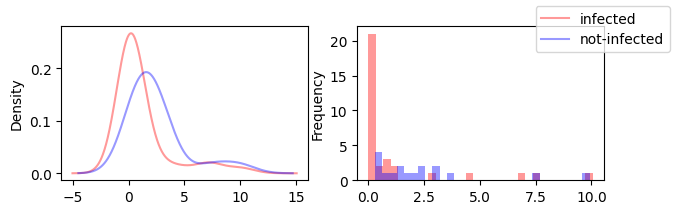

In [31]:

pp("#### Balancing problem")

pp(
    "The data set is largely unbalanced towards the @infected ones, "\
    "due to the higher cost of producing this type of network traffic:"
)


tmp = DF.rename(columns={"id": "count"})[["count", "qr", "u", "dga"]].groupby("dga").agg({"count": "count", "qr": "sum", "u": "sum"})
tmp.index.rename(None, inplace=True)

tmp["qr"] /= tmp["count"]
tmp["u"] /= tmp["count"]
tmp = tmp.map(lambda x: qq.Quantity(x).render(prec=2))

pt(tmp,
   width='350px',
   caption="Average number of requests and uniques per @capture.")


pp(f"If we consider the **duration**, we will have the following unbalancing ratios:")

tmp = DF.copy()
for col in ["q"]:
    tmp[f"{col}/s"] = tmp[f"{col}"] / tmp["duration"]

fig, axs = plt.subplots(1,2, figsize=(7,2))
ax = tmp[tmp["dga"]=="infected"][["q/s", "dga"]].plot(kind="kde", ax=axs[0], color="#FF000066", legend=False)
tmp[tmp["dga"]=="not-infected"][["q/s", "dga"]].plot(kind="kde", ax=axs[0], color="#0000FF66", legend=False)
fig.legend(["infected", "not-infected"])
ax = tmp[tmp["dga"]=="infected"][["q/s", "dga"]].plot.hist(ax=axs[1], bins=30, color="#FF000066", legend=False)
ax = tmp[tmp["dga"]=="not-infected"][["q/s", "dga"]].plot.hist(ax=axs[1], bins=30, color="#0000FF66", legend=False)

tmp = tmp[["q/s", "dga"]].groupby("dga").describe()
tmp.index.rename(None, inplace=True)

pt(
    tmp.map(lambda x: qq.Quantity(x).render(prec=2)),
    width="350px",
    caption="Average number of queries/uniques per second grouped by the infection class."
)

pp([
    "We can note that:",
    "\n- the @not-infected $q/s$ are more _sparse_ relatevely to the @infected ones."
    "- the @infected $q/s$ average is lower than the @not-infected one.\n"
])

pp([
    "\nThe problem is that the duration is very different for the two kind of captures."
])

tmp = DF.copy()
for col in ["u"]:
    tmp[f"{col}/s"] = tmp[f"{col}"] / tmp["duration"]
tmp = tmp[[ "u/s", "dga"]].groupby("dga").describe()
tmp.index.rename(None, inplace=True)

#### Balancing problem

The data set is largely unbalanced towards the @infected ones, due to the higher cost of producing this type of network traffic:

NameError: name 'pt' is not defined

#### Captures duration

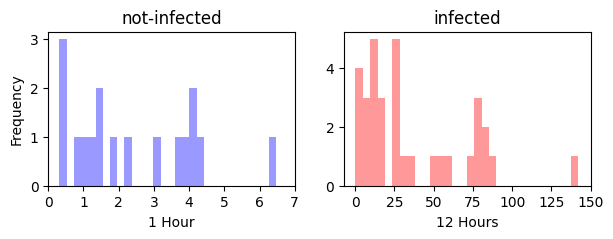

| dga          | ('duration', 'mean')   | ('duration', 'std')   | ('duration', 'min')   | ('duration', '25%')   | ('duration', '50%')   | ('duration', '75%')   | ('duration', 'max')   |
|:-------------|:-----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|:----------------------|
| infected     | 18 days                | 17 days               | 1.4 min               | 5.6 days              | 13 days               | 30 days               | 71 days               |
| not-infected | 2.4 hr                 | 1.8 hr                | 19 min                | 1.1 hr                | 1.9 hr                | 3.9 hr                | 6.5 hr                |

The capture duration is higly unbalanced. More precisely:
- The maximum duration for @not-infected is just 6.5 hours respect the 71 days of the @infected ones.
- The average duration for @not-infected is just 2.4 hours while the @infected one is 18 days.

In [37]:
pp("#### Captures duration")

tmp = DF[["duration", "dga"]].copy()

fig, axs = plt.subplots(1,2, figsize=(7, 2))
hours = (1 * 60 * 60)
tmp = DF[["duration", "dga"]].copy()
tmp["duration"] = tmp["duration"] / hours
tmp[tmp["dga"] == "not-infected"].plot.hist(
    ax=axs[0],
    bins=30,
    legend=False,
    title="not-infected",
    color="#0000FF66"
)
axs[0].set_xlabel("1 Hour")
# axs[0].set_yticks([0,1,2,3])
axs[0].set_xticks([0,1,2,3,4,5,6,7])
hours = (12 * 60 * 60)
tmp = DF[["duration", "dga"]].copy()
tmp["duration"] = tmp["duration"] / hours
tmp[tmp["dga"] == "infected"].plot.hist(
    ax=axs[1],
    legend=False,
    bins=30,
    title="infected",
    color="#FF000066"
)
axs[1].set_xlabel("12 Hours")
axs[1].set_ylabel(None)
axs[1].set_xticks([0,25,50,75,100,125,150])
plt.show()


hours = (1 * 60 * 60)
tmp = DF[["duration", "dga"]].copy()
tmp["duration"] = tmp["duration"] / hours
pt(tmp
       .groupby("dga")
       .describe()
       .drop(columns=("duration", "count"))
       .map(ptime))

pp([
    "The capture duration is higly unbalanced. More precisely:",
    "- The maximum duration for @not-infected is just 6.5 hours respect the 71 days of the @infected ones."
    "\n- The average duration for @not-infected is just 2.4 hours while the @infected one is 18 days."
])

In [3]:

display(Markdown("## Data set analysis"))

display(Markdown("The number of requests over time have been calculated dividing the timeline in the so called slots.The slot value chosen is of 3600 seconds."))

display(Markdown("\n".join([
    "## Timestamp translation",
    "Since that we have different source, captured in different times, and we want to simulate a SOC receiving alarms, we set the "
    "starting moment of each source to 0 s, translating all the requests accordingly:"
])))

times_s = database.conn.execute(text(f"""
    SELECT MAX(M.TIME_S) TIME_S,  MAX(M.TIME_S_TRANSLATED) TIME_S_TRANSLATED
    FROM MESSAGE M JOIN PCAP ON M.PCAP_ID = PCAP.ID
    WHERE PCAP.DATASET = '{DATASET}'
""")).all()[0]._mapping

display(Markdown("\n".join([
    "- The last request timestamp is: %s (%s days)." % (times_s["time_s"], math.floor(times_s["time_s"] / dataset.DAY_SEC)),
    "- The last request timestamp *translated* is: %s (%s days)." % (times_s["time_s_translated"], math.floor(times_s["time_s_translated"] / dataset.DAY_SEC))
])))

display(Markdown("\n".join([
    "### Distribution of slots",
    "The slot value chosen is of %s seconds." % SEC_PER_SLOT
])))

tmp = slot.groupsum(["q"], []).reset_index(level=0, drop=True)
tmp_perc = ((tmp.cumsum() / tmp.sum()) * 100).round(2)
desc = tmp_perc.describe(percentiles=[0.95, 0.99, 0.999])
display(Markdown(desc.to_frame().T.to_markdown()))

q_left50perc = tmp.cumsum().iloc[int(tmp.shape[0] / 2)]
q_right50perc = tmp.sum() - q_left50perc
display(Markdown("\n".join([
    "Setting the slot value equal to %.2fs days or %.2f hours, the maximum number of slots is %d." % (SEC_PER_SLOT / dataset.DAY_SEC, SEC_PER_SLOT / (60 * 60), slot.df["slotnum"].max()),
    "\nThis huge number is misplacing, since:",
    "- The %02.2f%% (%s) of requests are within the first 50%% of the slots." % (desc.loc['50%'], q_left50perc),
    "- The %02.2f%% (%s) of requests are within the last 50%% slots." % (100 - desc.loc['50%'], q_right50perc)
])))

th_slotnum = int(slot.df["slotnum"].max() / 2)

display(Markdown("\n".join([
    "Therefore:",
    "> We decide to ignore the last 50%% of the slots, corresponding to %d of %d slots." % (th_slotnum, slot.df["slotnum"].max())
])))


## Data set analysis

The number of requests over time have been calculated dividing the timeline in the so called slots.The slot value chosen is of 3600 seconds.

## Timestamp translation
Since that we have different source, captured in different times, and we want to simulate a SOC receiving alarms, we set the starting moment of each source to 0 s, translating all the requests accordingly:

- The last request timestamp is: 1493733000.0 (17288 days).
- The last request timestamp *translated* is: 6135434.0 (71 days).

### Distribution of slots
The slot value chosen is of 43200 seconds.

|    |   count |   mean |     std |   min |   50% |   95% |   99% |   99.9% |   max |
|---:|--------:|-------:|--------:|------:|------:|------:|------:|--------:|------:|
|  0 |     143 | 90.645 | 17.2678 | 10.84 | 98.63 | 99.99 |   100 |     100 |   100 |

Setting the slot value equal to 0.50s days or 12.00 hours, the maximum number of slots is 142.

This huge number is misplacing, since:
- The 98.63% (13170259) of requests are within the first 50% of the slots.
- The 1.37% (183153) of requests are within the last 50% slots.

Therefore:
> We decide to ignore the last 50% of the slots, corresponding to 71 of 142 slots.

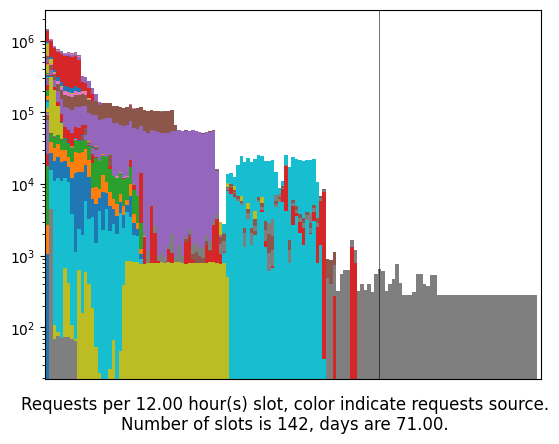

In [8]:
MAX_SLOTNUM = slot.df["slotnum"].max()
MAX_SLOTNUM_DAY = MAX_SLOTNUM / slot.SLOTS_PER_DAY
th_slotnum = int(MAX_SLOTNUM / 2) + 25

txt = f"Requests per {slot.HOUR_PER_SLOT:.2f} hour(s) slot, color indicate requests source.\nNumber of slots is {MAX_SLOTNUM}, days are {MAX_SLOTNUM_DAY:.2f}."
tmp = slot.groupsum([ "q", "pcap_id"], ["pcap_id"], days=-1)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False)
ax.set_xticks([])
ax.set_xlabel("")
ax.axvline(th_slotnum, color="black", linewidth=0.4)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

# Number of requests per *12.0-hours* slot

We observe:
- The number of not-infected slots is much lower than the number of infected ones.- The not-infected slots are relagated just to the firsts slots.

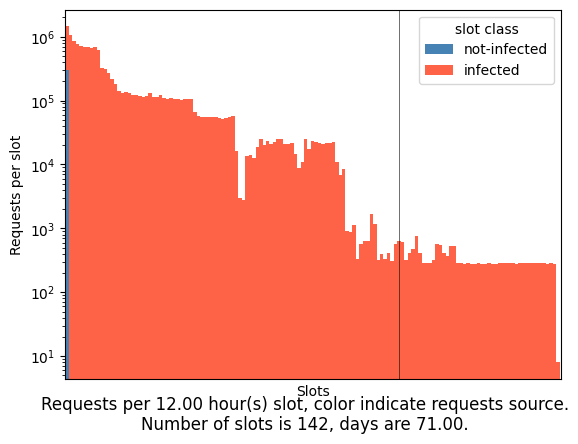

In [9]:
MAX_SLOTNUM = slot.df["slotnum"].max()
MAX_SLOTNUM_DAY = MAX_SLOTNUM / slot.SLOTS_PER_DAY
th_slotnum = int(MAX_SLOTNUM / 2) + 25

txt = f"Requests per {slot.HOUR_PER_SLOT:.2f} hour(s) slot, color indicate requests source.\nNumber of slots is {MAX_SLOTNUM}, days are {MAX_SLOTNUM_DAY:.2f}."
tmp = slot.groupsum([ "q", "dga"], ["dga"], days=-1)
tmp.rename(columns={ 0: "not-infected", 2: "infected"}, inplace=True) # ignore
tmp.columns.rename("slot class", inplace=True)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=True, color=[ "steelblue", "tomato" ])
ax.set_xticks([])
ax.set_ylabel("Requests per slot")
ax.set_xlabel("Slots")
ax.axvline(th_slotnum, color="black", linewidth=0.4)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)


pp(f"# Number of requests per *{slot.HOUR_PER_SLOT}-hours* slot")

pp([
    f"We observe:",
    f"- The number of not-infected slots is much lower than the number of infected ones."
    f"- The not-infected slots are relagated just to the firsts slots."
])

plt.show()


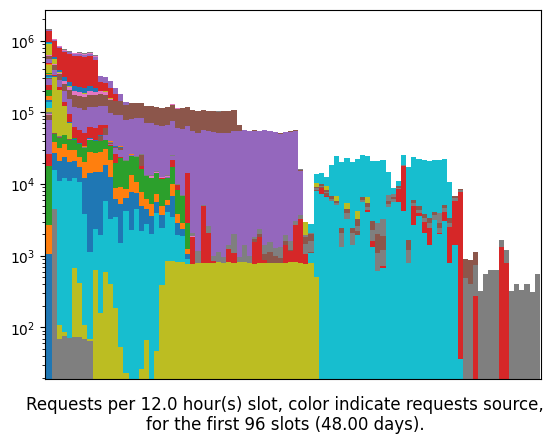

In [10]:
th_days = int(th_slotnum / slot.SLOTS_PER_DAY)

txt = f"Requests per {slot.HOUR_PER_SLOT} hour(s) slot, color indicate requests source,\nfor the first {th_slotnum} slots ({th_slotnum / slot.SLOTS_PER_DAY:.2f} days)."

tmp = slot.groupsum([ "q", "pcap_id"], ["pcap_id"], days=th_days)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False)
ax.set_xticks([])
ax.set_xlabel("")
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

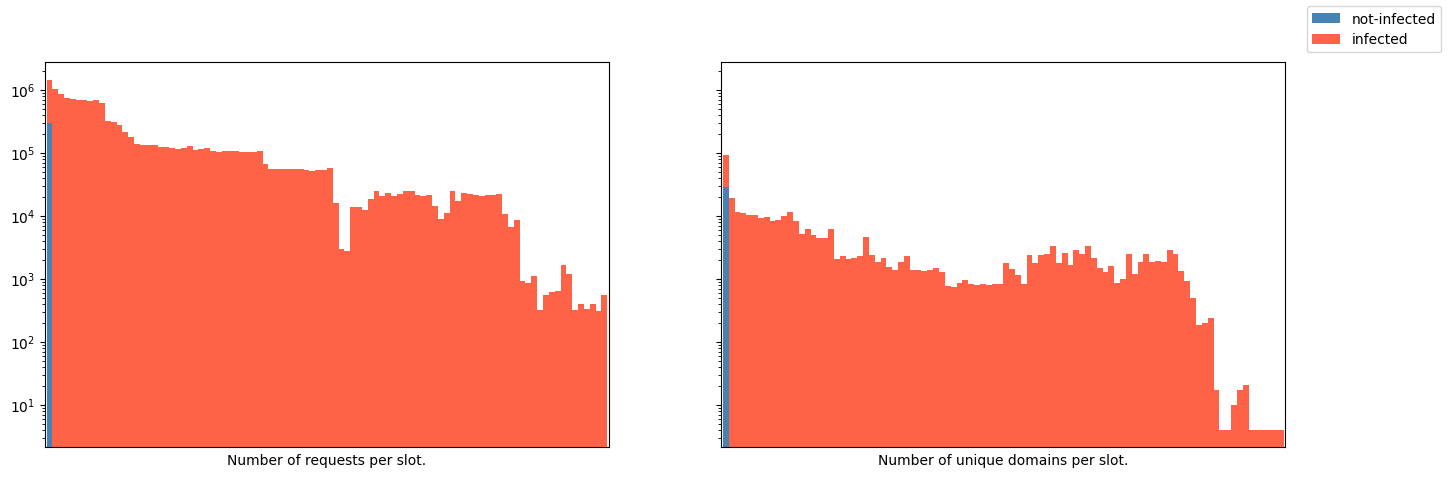

In [11]:
fig, axsp = plt.subplots(1, 2, sharey=True)


txt = f"Number of requests per slot."
tmp = slot.groupsum([ "q", "dga"], ["dga"], days=th_days)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False, color=[ "steelblue", "tomato" ], ax=axsp[0])
axsp[0].set_xticks([])
axsp[0].set_xlabel(txt)


txt = f"Number of unique domains per slot."
tmp = slot.groupsum([ "u", "dga"], ["dga"], days=th_days)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False, color=[ "steelblue", "tomato" ], ax=axsp[1])
axsp[1].set_xticks([])
axsp[1].set_xlabel(txt)


axsp[1].set_ylabel("Request domains")
axsp[1].set_ylabel("Unique domains")

fig.set_figwidth(16)
fig.set_figheight(5)
fig.legend(["not-infected", "infected"])

plt.show()

In [12]:


plt.show()

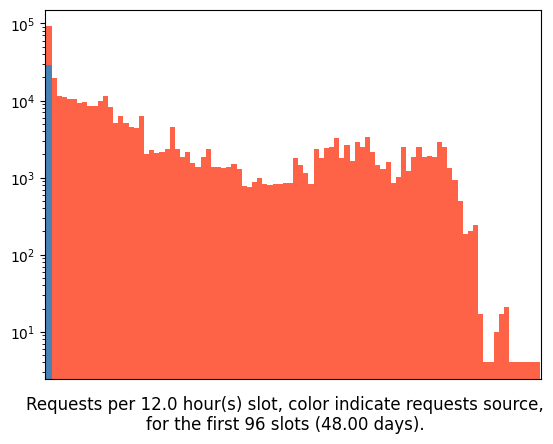

In [13]:
th_days = int(th_slotnum / slot.SLOTS_PER_DAY)

txt = f"Requests per {slot.HOUR_PER_SLOT} hour(s) slot, color indicate requests source,\nfor the first {th_slotnum} slots ({th_slotnum / slot.SLOTS_PER_DAY:.2f} days)."

tmp = slot.groupsum([ "u", "dga"], ["dga"], days=th_days)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False, color=[ "steelblue", "tomato" ])
ax.set_xticks([])
ax.set_xlabel("")
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

# First 5 days

## Windows over time

The number of windows active for a slot of time, which is 3600 seconds.

The last window timestamp is: 1493733000.0 (17288 days).

The last window timestamp _normalized_ is: 431998.951 (4 days).

Then, whit the slot value equal to 0. days, the maximum number of slot is 119.

This huge number is misplacing, since the:
- 163090 windows (the 99%) are within the first 117.0 slots.
- 1155 windows (the 1%) are within the last 2.0 slots.

> We decide to ignore the last 103893 windows, corresponding to the last 89.0 slots.

#### Pitfall **Spurius Correlations** for *window\_time\_start*:

> It's obvious that time start/end should not be used.

This plot demonstrate that using the _window\_time\_start/end_ feature would establish a correlation with the DGA class, since just DGA windows starts after the first slot.

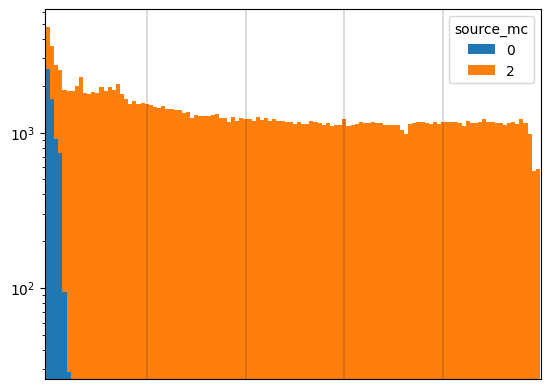

# The window distribution over sources

We can see that there are 

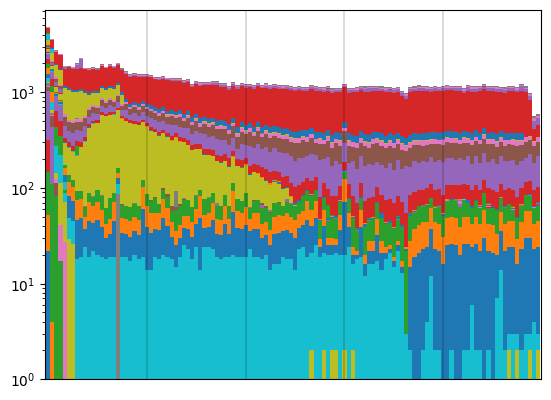

# Positives with threshold 0.5

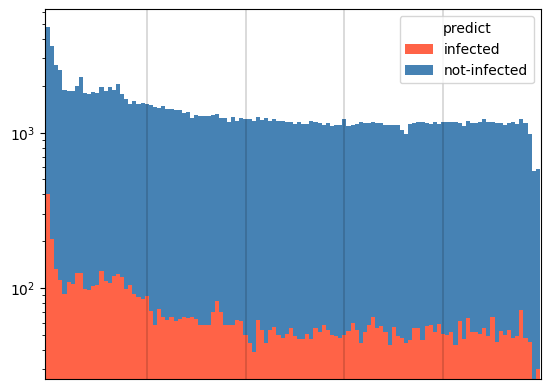

In [14]:
SEC_PER_SLOT = 1 * 60 * 60
DAY_SEC = 24 * 60 * 60
N_DAYS = 5
SLOT_PER_DAY = DAY_SEC / SEC_PER_SLOT

df = dataset.df.copy().sort_values("time_s_end_norm")
df = df[df["time_s_end_norm"] < N_DAYS * DAY_SEC]
n_slot_max = math.floor(df["time_s_end_norm"].max() / SEC_PER_SLOT)
df["slot_end"] =  np.floor(df["time_s_end_norm"] / SEC_PER_SLOT)

display(Markdown("# First %s days" % N_DAYS))

display(Markdown("## Windows over time"))
display(Markdown("The number of windows active for a slot of time, which is %s seconds." % SEC_PER_SLOT))


display(Markdown("The last window timestamp is: %s (%s days)." %(df["time_s_end"].max(), math.floor(df["time_s_end"].max() / DAY_SEC))))
display(Markdown("The last window timestamp _normalized_ is: %s (%s days)." % (df["time_s_end_norm"].max(), math.floor(df["time_s_end_norm"].max() / DAY_SEC))))



desc = df["slot_end"].describe(percentiles=[0.95, 0.99, 0.999])

display(Markdown("Then, whit the slot value equal to %.2s days, the maximum number of slot is %s." % (SEC_PER_SLOT / DAY_SEC, n_slot_max)))
display(Markdown("""This huge number is misplacing, since the:
- %s windows (the 99%%) are within the first %s slots.
- %s windows (the 1%%) are within the last %s slots.""" % ((df["slot_end"] <= desc.loc['99%']).sum(), desc.loc['99%'], (df["slot_end"] > desc.loc['99%']).sum(), df["slot_end"].max() - desc.loc['99%'])))


n_slot_th = 30

display(Markdown("> We decide to ignore the last %s windows, corresponding to the last %s slots." % ((df["slot_end"] > n_slot_th).sum(), df["slot_end"].max() - n_slot_th)))




display(Markdown("#### Pitfall **Spurius Correlations** for *window\\_time\\_start*:"))

display(Markdown("> It's obvious that time start/end should not be used."))

display(Markdown("This plot demonstrate that using the _window\\_time\\_start/end_ feature would establish a correlation with the DGA class, since just DGA windows starts after the first slot."))

tmp = df[["source_mc", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
ax.set_xticks([])
ax.set_xlabel(None)
plt.show()



display(Markdown("# The window distribution over sources"))
display(Markdown("We can see that there are "))
tmp = df[["source_id", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=False)
ax.set_xticks([])
ax.set_xlabel(None)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
    # ax.text(day * DAY_SEC / SLOT_SEC + 0.1, 0,  'blah', rotation=90)
plt.show()



display(Markdown("# Positives with threshold 0.5"))
df["predict"] = "infected"
df["predict"] = df["predict"].where(df["eps_NONE_0.500"] > 0.5, "not-infected")
tmp = df[["predict", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=True, legend=True, color=[ "tomato", "steelblue"])
ax.set_xticks([])
ax.set_xlabel(None)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
plt.show()


### Using threshold 0.5

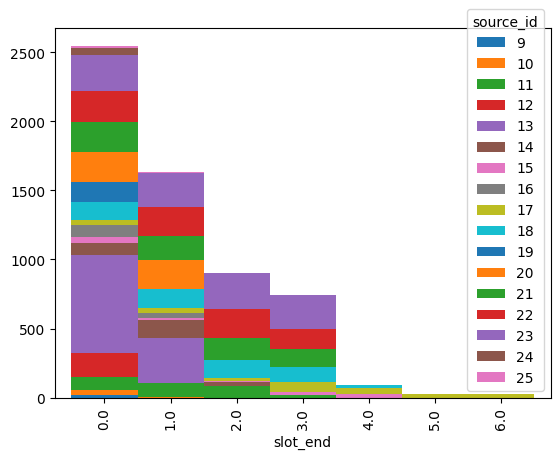

### Using threshold 0.5

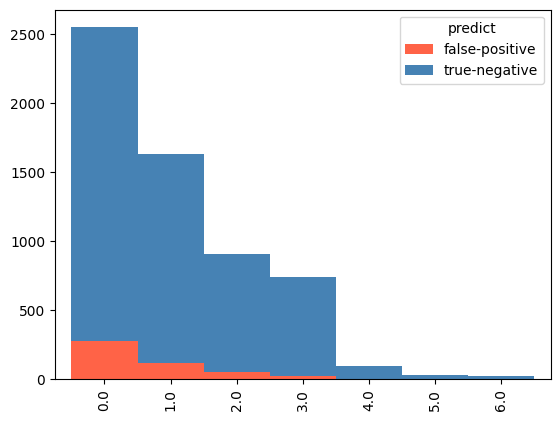

In [15]:
SEC_PER_SLOT = 1 * 60 * 60
DAY_SEC = 24 * 60 * 60
N_DAYS = 1
SLOT_PER_DAY = DAY_SEC / SEC_PER_SLOT

df = dataset.df.copy().sort_values("time_s_end_norm")
df = df[df["source_mc"] == 0]
df["slot_end"] =  np.floor(df["time_s_end_norm"] / SEC_PER_SLOT)

display(Markdown("### Using threshold 0.5"))



tmp = df[["source_id", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=False, legend=True)
plt.show()

display(Markdown("### Using threshold 0.5"))

df["predict"] = "false-positive"
df["predict"] = df["predict"].where(df["eps_NONE_0.500"] > 0.5, "true-negative")

tmp = df[["predict", "slot_end"]].reset_index(drop=True).value_counts().unstack().T.fillna(0)
ax = tmp.plot(kind="bar", width=1, stacked=True, logy=False, legend=True, color=[ "tomato", "steelblue"])
# ax.set_xticks([])

ax.set_xlabel(None)
for day in range(1, N_DAYS):
    ax.axvline(day * SLOT_PER_DAY, color="black", linewidth=0.2)
plt.show()

In [ ]:
w_sec = 24 * 60 * 60
df = dataset.df.copy().sort_values("time_s_end")

df = df#.iloc[0:1000]

n_windows_max = math.floor(df["time_s_end"].max() / w_sec)
print(df["time_s_end"].max(), n_windows_max)

# df = df[df["time_s_end"] < w_sec * 200]

df["w_plot_end"] =  np.floor(df["time_s_end"] / w_sec)

print(df["w_plot_end"].describe(percentiles=[0.95, 0.99]))

display(df["w_plot_end"].hist())

n_windows = math.floor(df["time_s_end"].max() / w_sec)

print(df["time_s_end"].max(), n_windows)

bins = np.zeros((n_windows, 2))
print(math.floor(df["time_s_end"].max() / w_sec))
for row, window in df.iterrows():
    bin_start = math.floor(window["time_s_start"] / w_sec) # type: ignore
    bin_end = math.floor(window["time_s_end"] / w_sec) # type: ignore

    bins[bin_start:bin_end, 0] += 1
    bins[bin_start:bin_end, 1] += 1 if window["eps_NONE_0.500"] > 0 else 0
    pass

dftmp = pd.DataFrame(bins, columns=["nw", "p"])
dftmp["nw"] -= dftmp["p"]
dftmp.plot.bar(stacked=True, width=1)#log=False, sharex=True, stacked=True, histtype="step")

In [ ]:
df = dataset.df[dataset.df[("source_mc")] == 0].copy()
df.time_s_start = df.time_s_start.astype(int)

# df.xs('-', level=0, axis=1).xs('-', level=0, axis=1)

first_time_s_start = df[["source_id", "time_s_start"]]
first_time_s_start = first_time_s_start.groupby("source_id").min().reset_index()
first_time_s_start = first_time_s_start.rename(columns={ "time_s_start": "first_time_s_start" })

first_time_s_start = df.merge(first_time_s_start, suffixes=["", ""], left_on=["source_id"], right_on=["source_id"], validate="many_to_one")#[("-", "-", "first_time_s_start")]

display(first_time_s_start[[ "time_s_start", "first_time_s_start"]])
display(first_time_s_start["time_s_start"] - first_time_s_start["first_time_s_start"])

# df["-", "-", "common_start_time_s"] = df["-", "-", "time_s_start"] - first_time_s_start

# df.sort_values(by=[("-", "source", "id"), ("-", "-", "index")], ascending=False)

In [ ]:

# df_normal_approach.reset_index(level=[1,2], names=['nn'])

# df_normal_approach.reset_index(level=[1,2], names=['nn', 'th']).groupby(['nn', 'th']).mean()
tmp = df_normal_approach.reset_index(level=[1,2], names=['id','nn','th'])

# tmp.groupby(['nn', 'th']).describe().round(2).drop(['q', 'u'], level=0, axis=1)
tmp.groupby(['nn', 'th']).describe().round(2).xs('fp', level=0, axis=1)


In [ ]:
from IPython.display import display, Markdown, Latex

display(Markdown("# fp_rate_min"))

display(tmp.groupby(['nn', 'th']).describe().round(2).xs('fp_rate_min', level=0, axis=1))

In [ ]:
from IPython.display import display, Markdown, Latex

display(Markdown("# u_fp_rate_min"))

display(tmp.groupby(['nn', 'th']).describe().round(2).xs('u_fp_rate_min', level=0, axis=1))

In [ ]:
from IPython.display import display, Markdown, Latex

display(Markdown("# u_fp_rate_min"))

display(tmp.groupby(['nn', 'th']).describe().round(2).xs('u_fp_rate_min', level=0, axis=1))

In [ ]:
from IPython.display import display, Markdown, Latex

df_na_th = df_normal_approach.reset_index(level=[1,2], names=['id','nn','th'])

ei = df_na_th[df_na_th['th'] == '0.100']["fp"].sort_values()
print( ei.iloc[int(ei.shape[0] * 0.25)] / 2+ ei.iloc[int(ei.shape[0] * 0.25)-1] / 2)

display(Markdown("# Grouping by sources and NN"))
display(Markdown("## FP"))
display(df_na_th.groupby(['th']).describe().round(2).xs('fp', level=0, axis=1))
display(Markdown("## fp_rate_min"))
display(df_na_th.groupby(['th']).describe().round(2).xs('fp_rate_min', level=0, axis=1))
display(Markdown("## u_fp_rate_min"))
display(df_na_th.groupby(['th']).describe().round(2).xs('u_fp_rate_min', level=0, axis=1))